In [ ]:
import os
import pickle
import jsonlines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from openTSNE import TSNE
from typing import Tuple

In [ ]:
REPS_DIR = "/home/welton/data/representations"
LABELS_DIR = "/home/welton/data/datasets/labels"
ORACLE_DIR = "/home/welton/data/oracle"
REPS = [["bert", "bert_reps"]]
DATASETS = ["20ng", "acm"]

In [ ]:
def load_reps(reps_dir: str,
               dataset: str,
               rep: str,
               fold: int) -> Tuple[np.ndarray, np.ndarray]:
    if rep == "bert_reps":

        ids = pd.read_pickle(f"/home/welton/data/datasets/data/{dataset}/splits/split_10_with_val.pkl")
        lines = jsonlines.open(f"/home/welton/data/kaggle/{dataset}/{dataset}_bert{fold}.json")
        reps = [ [ l["id"], l["bert"] ] for l in lines ]
        df = pd.DataFrame(reps, columns=["id", "reps"])

        X_train = np.vstack(df.query(f"id == {ids['train_idxs'][fold]}").reps.values.tolist())
        X_test = np.vstack(df.query(f"id == {ids['test_idxs'][fold]}").reps.values.tolist())
        return X_train, X_test

    probs_dir = f"{reps_dir}/{dataset}/10_folds/{rep}/{fold}/"
    X_train = np.load(f"{probs_dir}/train.npz", allow_pickle=True)["X_train"].tolist().toarray()
    X_test = np.load(f"{probs_dir}/test.npz", allow_pickle=True)["X_test"].tolist().toarray()

    return X_train, X_test


In [ ]:
def train_tsne(X_train: np.ndarray, 
               tsne_path: str, 
               load_pickle: bool = False) -> TSNE:

    if load_pickle and os.path.exists(tsne_path):
        print("Loading Pre Trained TSNE")
        with open(tsne_path, 'rb') as fd:
            return pickle.load(fd)
    
    tsne = TSNE(
        perplexity=30,
        metric="euclidean",
        random_state=42,
        verbose=False,
        n_jobs=15
    )

    tsne_transformer = tsne.fit(X_train)
    with open(tsne_path, 'wb') as fd:
        pickle.dump(tsne_transformer, fd)
    return tsne_transformer

In [ ]:
tsne_embs = {}
for dataset in DATASETS:
    tsne_embs[dataset] = {}
    for rep_name, rep_path in REPS:
        tsne_embs[dataset][rep_name] = []
        for fold in np.arange(10):
            print(f"{dataset}/{rep_name} / FOLD: {fold}")
            
            X_train, X_test = load_reps(REPS_DIR, dataset, rep_path, fold)
            y_true = np.load(f"{LABELS_DIR}/split_10/{dataset}/{fold}/test.npy")
            tsne_path = f"../analysis_stacking/data/tsne_pickles/{dataset}/{rep_name}/{fold}"

            os.makedirs(tsne_path, exist_ok=True)
            tsne_path = f"{tsne_path}/model.pickle"

            transformer = train_tsne(X_train, tsne_path, load_pickle=True)
            test_reduced = transformer.transform(X_test)
            tsne_embs[dataset][rep_name].append(test_reduced)
            
    
        #tsne_embs[dataset][f"{rep_name}_stacked"] = np.vstack(tsne_embs[dataset][rep_name])
    

In [ ]:
tsne_embs["acm"]

In [ ]:
tsne_embs_bkp = tsne_embs

In [ ]:
with open("data/tsne_pickles/global_dict.pickle", 'wb') as fd:
    pickle.dump(tsne_embs, fd)

In [6]:
tsne_embs_path = "data/tsne_pickles/global_dict.pickle"
if os.path.exists(tsne_embs_path):
    with open(tsne_embs_path, 'rb') as fd:
        tsne_embs = pickle.load(fd)

In [7]:
dataset_labels = {}
for dataset in DATASETS:
    dataset_labels[dataset] = []
    for fold in np.arange(10):
        y = np.load(f"{LABELS_DIR}/split_10/{dataset}/{fold}/test.npy")
        dataset_labels[dataset].append(y)
    
    dataset_labels[f"{dataset}_folds"] = dataset_labels[dataset]
    dataset_labels[dataset] = np.hstack(dataset_labels[dataset])

In [8]:
oracle_ests = {}
for dataset in DATASETS:
    oracle_ests[dataset] = []
    for fold in np.arange(10):
        y = np.load(f"{ORACLE_DIR}/upper_bound/normal_probas/{dataset}/10_folds/bert/{fold}/test.npz")['y']
        oracle_ests[dataset].append(y)

In [9]:
error_ests = {}
for dataset in DATASETS:
    error_ests[dataset] = []
    for fold in np.arange(10):
        y = np.load(f"{ORACLE_DIR}/local_rf/normal_probas/{dataset}/10_folds/bert/dist_probas_probas_based/{fold}/test.npz")['y']
        error_ests[dataset].append(y)

In [10]:
colors = [
"#FF0000",
"#00FF00",
"#0000FF",
"#FFA500",
"#FFC0CB",
"#800080",
"#FFFF00",
"#00FFFF",
"#FF00FF",
"#008000",
"#800000",
"#000080",
"#808000",
"#FF8C00",
"#00FF7F",
"#FF1493",
"#8B008B",
"#4169E1",
"#228B22",
"#FFD700"]

In [14]:
def plot_folds(dataset: str, 
               clf: str, 
               dataset_labels: dict, 
               tsne_embs: dict, 
               oracle_ests: dict,
               error_ests: dict,
               colors: list):
    
    plt.figure(figsize=(42, 150))
    plot_idx = 0
    for fold in np.arange(3):
        
        plt.subplot(10, 3, plot_idx + 1)

        y_true = dataset_labels[f"{dataset}_folds"][fold]
        y_oracle = oracle_ests[dataset][fold]

        embs = tsne_embs[dataset][clf][fold]
        
        for doc_class in set(y_true):
            y_oracle = oracle_ests[dataset][fold]
            class_docs = embs[(y_true == doc_class) & (y_oracle == 1)]
            plt.scatter(class_docs[:, 0], class_docs[:, 1], marker=f'${doc_class}$', color=colors[doc_class])
            
        for doc_class in set(y_true):
            y_oracle = oracle_ests[dataset][fold]
            class_docs = embs[(y_true == doc_class) & (y_oracle == 0)]
            plt.scatter(class_docs[:, 0], class_docs[:, 1], marker=f'${doc_class}$', color=colors[doc_class], s=288)
        

        estimation = np.round(error_ests[dataset][fold])
        
        plt.subplot(10, 3, plot_idx + 2)
        for doc_class in set(y_true):
            y_oracle = oracle_ests[dataset][fold]
            class_docs = embs[(y_true == doc_class) & (y_oracle == 1)]
            plt.scatter(class_docs[:, 0], class_docs[:, 1], marker=f'${doc_class}$', color=colors[doc_class])

        for doc_class in set(y_true):
            y_oracle = oracle_ests[dataset][fold]
            class_docs = embs[(y_true == doc_class) & (y_oracle == 0) & (y_oracle == estimation)]
            plt.scatter(class_docs[:, 0], class_docs[:, 1], marker=f'${doc_class}$', color=colors[doc_class], s=288)

        plt.subplot(10, 3, plot_idx + 3)
        for doc_class in set(y_true):
            y_oracle = oracle_ests[dataset][fold]
            class_docs = embs[(y_true == doc_class) & (y_oracle == 1)]
            plt.scatter(class_docs[:, 0], class_docs[:, 1], marker=f'${doc_class}$', color=colors[doc_class])

        for doc_class in set(y_true):
            y_oracle = oracle_ests[dataset][fold]
            class_docs = embs[(y_true == doc_class) & (y_oracle == 0) & (y_oracle != estimation)]
            plt.scatter(class_docs[:, 0], class_docs[:, 1], marker=f'${doc_class}$', color=colors[doc_class], s=288)
        
        plot_idx += 3
        

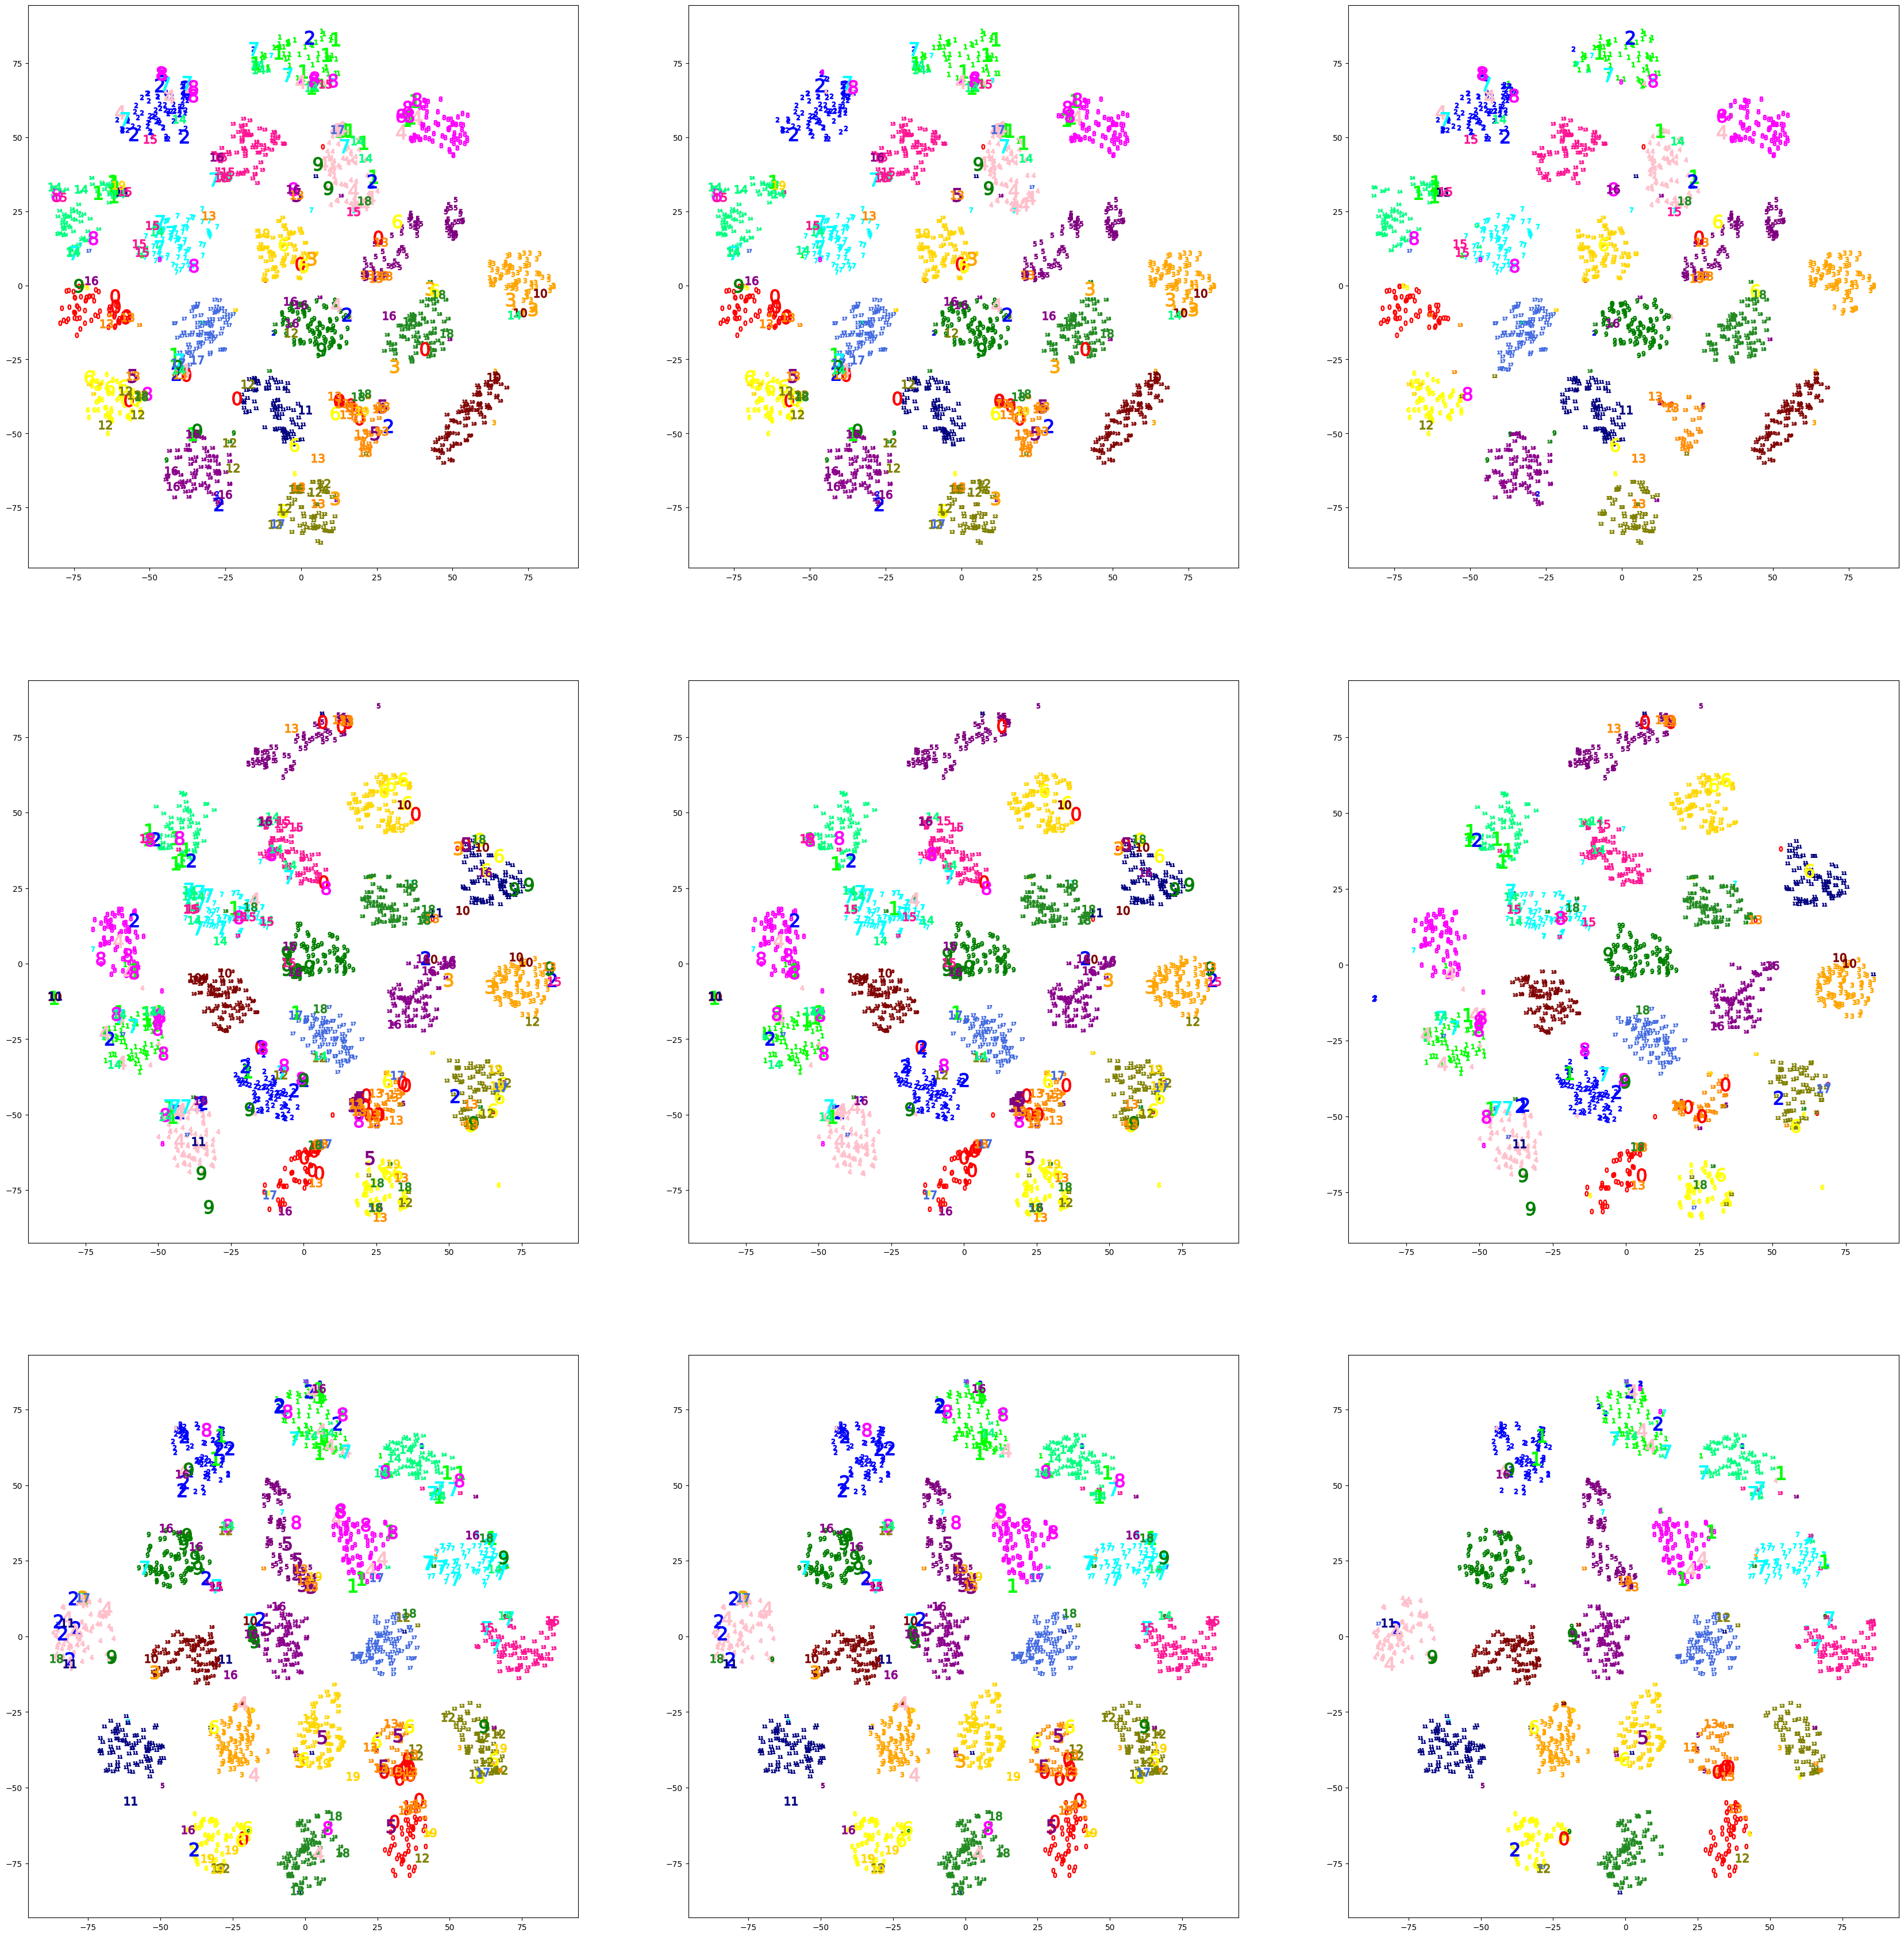

In [15]:
plot_folds("20ng", "bert", dataset_labels, tsne_embs, oracle_ests, error_ests, colors)

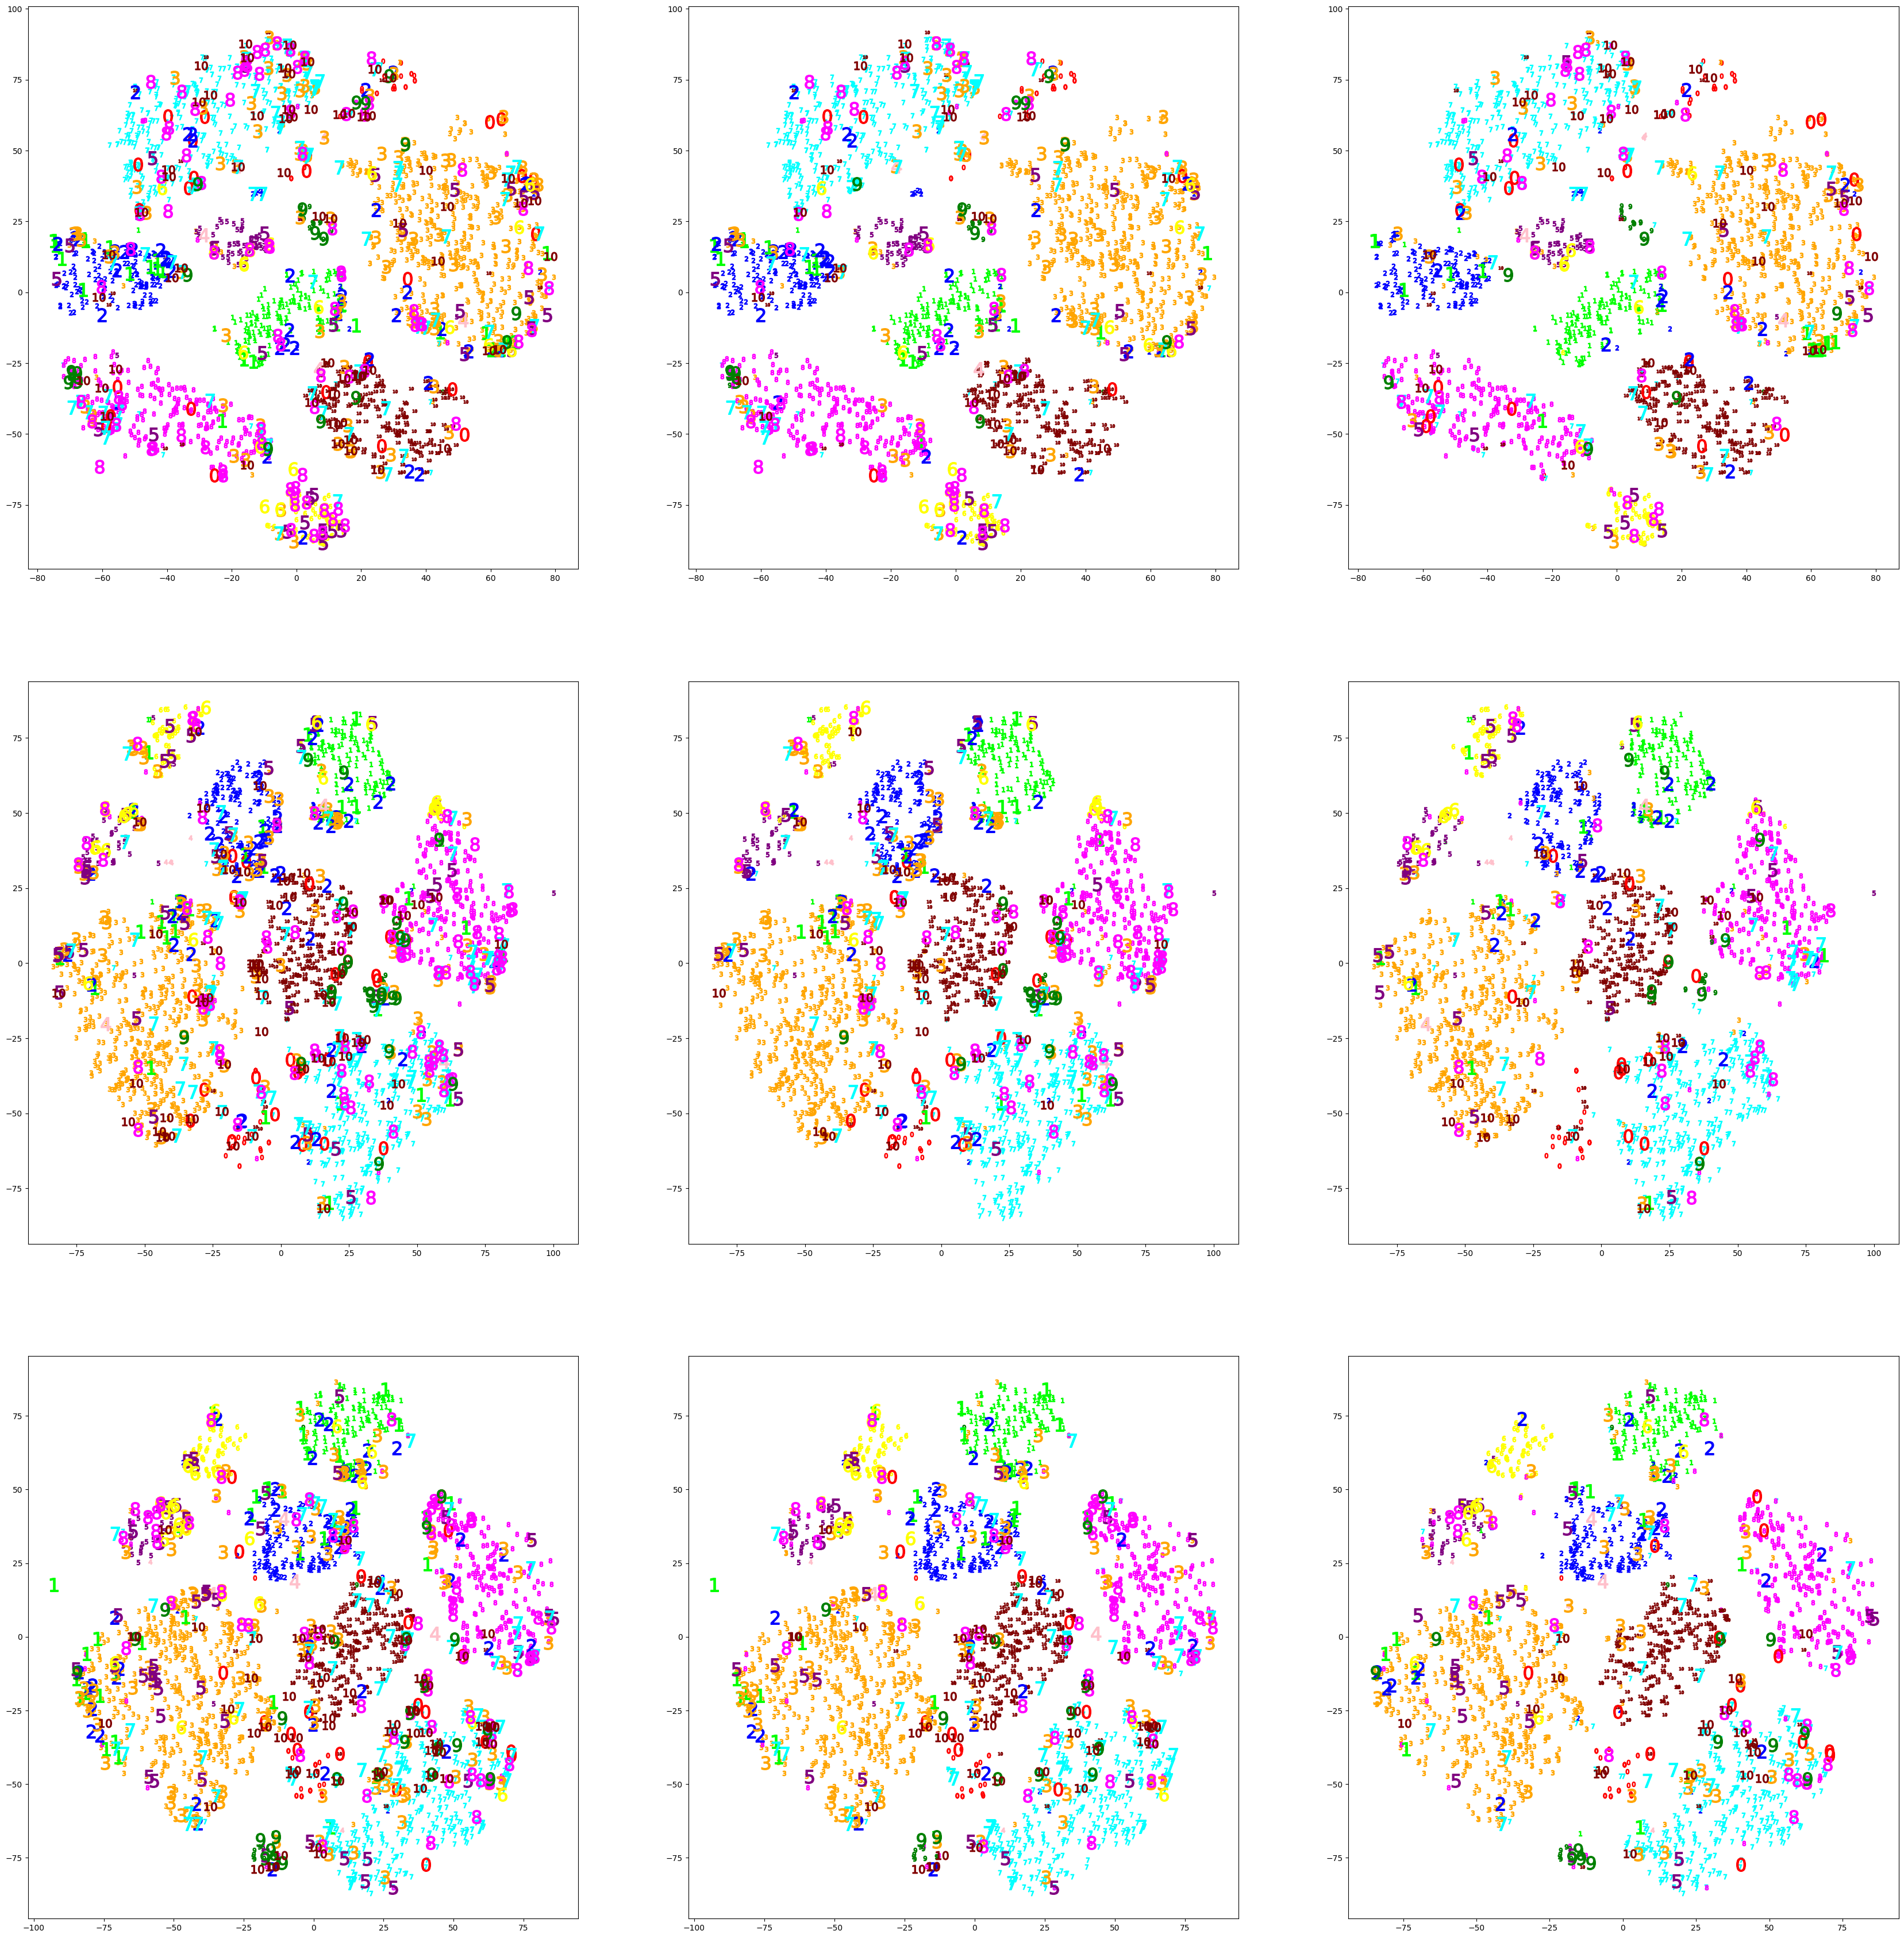

In [16]:
plot_folds("acm", "bert", dataset_labels, tsne_embs, oracle_ests, error_ests, colors)